In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import decomposition as d
from scikitplot import metrics as mt
from sklearn import metrics as m

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn import preprocessing as pp

np.set_printoptions(suppress=True)

2022-12-27 11:41:11.627755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 11:41:12.340167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-27 11:41:12.340207: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-27 11:41:12.414451: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-27 11:41:13.760171: W tensorflow/stream_executor/platform/de

In [2]:
path_data = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/data/'
path_model = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/models/'
path_transformation = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/transformation_data/'

In [3]:
data = pd.read_csv(path_data+'ciclo006_feature_selection_dataset.csv')

data.head()

,affiliate_channel,first_affiliate_tracked,age,signup_flow,days_from _first_active_until_account_created,days_from _account_created_until_booking,date_account_created_year,timestamp_first_active_year,date_first_booking_year,date_account_created_month,...,date_first_booking_week_sin,date_first_booking_week_cos,date_account_created_day_sin,date_account_created_day_cos,date_account_created_week_sin,date_account_created_week_cos,timestamp_first_active_week_sin,timestamp_first_active_week_cos,timestamp_first_active_day_sin,timestamp_first_active_day_cos
0,5.268086,5.280842,0.801870,0.0,0.578705,28.468750,0.00,0.600000,1.0,0.454545,...,0.000000,1.000000,-0.571268,0.820763,0.000000,1.000000,0.781831,0.623490,0.571268,0.820763
1,5.131527,5.280842,-0.158925,0.0,0.868441,23.296875,0.25,0.733333,1.0,0.363636,...,0.000000,1.000000,-0.937752,0.347305,0.974928,-0.222521,0.781831,0.623490,0.848644,0.528964
2,5.268086,5.280842,1.413285,3.0,-0.279754,-0.078125,0.00,0.266667,0.0,0.727273,...,0.000000,1.000000,-0.571268,0.820763,0.781831,0.623490,-0.781831,0.623490,0.937752,0.347305
3,5.268086,5.280842,0.190455,0.0,1.567955,4.265625,0.25,1.000000,0.4,1.000000,...,-0.974928,-0.222521,0.848644,0.528964,0.000000,1.000000,0.974928,-0.222521,0.897805,-0.440394
4,5.268086,5.280842,0.103110,0.0,-0.279754,-0.078125,0.00,0.233333,0.0,0.727273,...,0.433884,-0.900969,0.299363,-0.954139,0.781831,0.623490,-0.433884,-0.900969,0.651372,-0.758758


## Aplicando PCA

In [4]:
x = data.drop('country_destination', axis=1)
y = data['country_destination'].copy()

In [5]:
y.value_counts()

US       121057
NDF      119810
FR       116846
IT       110848
other    108793
GB       102656
ES        98982
CA        98204
DE        98051
NL        96923
AU        94631
PT        93716
Name: country_destination, dtype: int64

In [7]:
# Split Training and Test
x, x_test, y, y_test = train_test_split(x, y, test_size=0.1, random_state=32)

In [13]:
#Split Training and validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

# y for NN
ohe = pp.OneHotEncoder()

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_val = ohe.transform(y_val.values.reshape(-1, 1)).toarray()

# MLP: Neural Network
# Model definition
model = Sequential()

model.add(Dense(128, input_dim = x_train.shape[1], activation='relu'))
model.add(Dense(12, activation='softmax'))

# model compile
#opt = SGD( lr= 0.01, momentum= 0.8)

model.compile( loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

# model fit (training)
es = EarlyStopping(monitor='val_loss' , patience=10)

model.fit(x_train, y_train, epochs=100, verbose=0, callbacks=[es])


# Model accuracy
_, acc_train = model.evaluate(x_train, y_train, verbose=0)
_, acc_val = model.evaluate(x_val, y_val, verbose=0)

print( 'Training ACC: {} - Validation ACC: {}'.format(acc_train, acc_val))

# Learning Curve
#plt.plot(history.history['loss'], label = 'Training')
#plt.plot(history.history['val_loss'], label = 'validation')
#plt.legend()

Training ACC: 0.3721412718296051 - Validation ACC: 0.36947372555732727


In [14]:
y_test_nn = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

_, test_acc = model.evaluate(x_test, y_test_nn, verbose= 0 )

print('Test ACC: {}'.format(test_acc))


Test ACC: 0.3673563301563263


In [52]:
pred_nn = model.predict(x_test)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)
#y_test_nn = ohe.inverse_transform(y_test)
#prediction prepare
y_test_nn = y_test
yhat_nn = yhat_nn.reshape(1, -1)[0]

3940/3940 [==============================] - 2s 450us/step


Accuracy: 0.3673563291340082
Balanced Accuracy: 0.367859512466673
Kappa Score: 0.3094952951924361


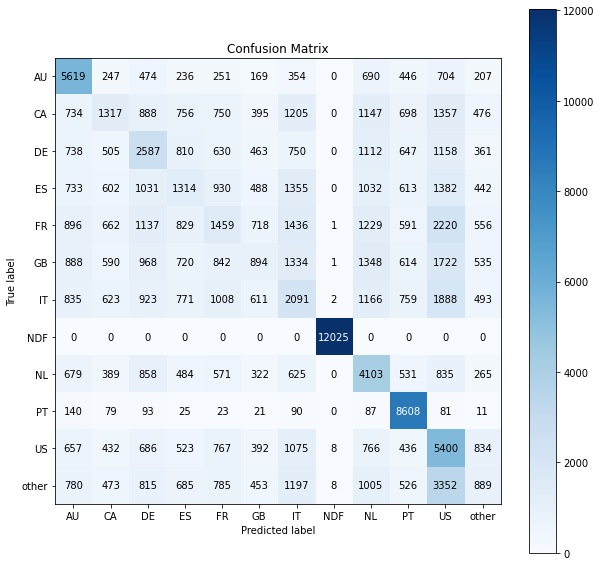

In [55]:
#Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

#Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize= False, figsize=(10,10))

#Balanced Accuracy
balanced_accuracy = m.balanced_accuracy_score(y_test_nn, yhat_nn )
print('Balanced Accuracy: {}'.format(balanced_accuracy))

#Kappa Metrics
kappa_score = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_score))

#Objetivo é aumentar o Balanced Accuracy para uns 85% (Acuracia para apresentar ao time de negocio
#Kappa Score uns 75% (Nivel de concordancia entre as classes).

#print(m.classification_report(y_val_nn, yhat_nn))

# Com PCA

In [56]:
#Split Training and validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

# PCA
#Standardization (Centraliza e rescalar)
ss = pp.StandardScaler()
x_train_scaler = ss.fit_transform(x_train)
x_val_scaler = ss.transform(x_val)

#Define the number of eigenvectors (autovetor) + eigenvalues (Autovalores)
pca = d.PCA().fit(x_train_scaler)
k = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)

#Change data to new space
pca = d.PCA(k).fit(x_train_scaler)

x_train = pca.transform(x_train_scaler)
x_val = pca.transform(x_val_scaler)


# y for NN
ohe = pp.OneHotEncoder()

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_val = ohe.transform(y_val.values.reshape(-1, 1)).toarray()

# MLP: Neural Network
# Model definition
model = Sequential()

model.add(Dense(128, input_dim = x_train.shape[1], activation='relu'))
model.add(Dense(12, activation='softmax'))

# model compile
opt = SGD( lr= 0.01, momentum= 0.8)

model.compile( loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

# model fit (training)
es = EarlyStopping(monitor='val_loss' , patience=10)

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, verbose=0, callbacks=[es])

# model evaluete 

# Model accuracy
_, acc_train = model.evaluate(x_train, y_train, verbose=0)
_, acc_val = model.evaluate(x_val, y_val, verbose=0)

print( 'Training ACC: {} - Validation ACC: {}'.format(acc_train, acc_val))

# Learning Curve
#plt.plot(history.history['loss'], label = 'Training')
#plt.plot(history.history['val_loss'], label = 'validation')
#plt.legend()

/home/wellington/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training ACC: 0.35963207483291626 - Validation ACC: 0.35508808493614197


In [57]:
x_test_nn = pca.transform(ss.transform(x_test))
y_test_nn = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

_, test_acc = model.evaluate(x_test_nn, y_test_nn, verbose= 0 )

print('Test ACC: {}'.format(test_acc))


Test ACC: 0.35667818784713745


In [58]:
pred_nn = model.predict(x_test_nn)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)
#y_test_nn = ohe.inverse_transform(y_test)
#prediction prepare
y_test_nn = y_test
yhat_nn = yhat_nn.reshape(1, -1)[0]

3940/3940 [==============================] - 2s 429us/step


Accuracy: 0.3566781962999397
Balanced Accuracy: 0.3595810612238049
Kappa Score: 0.29887947727417963


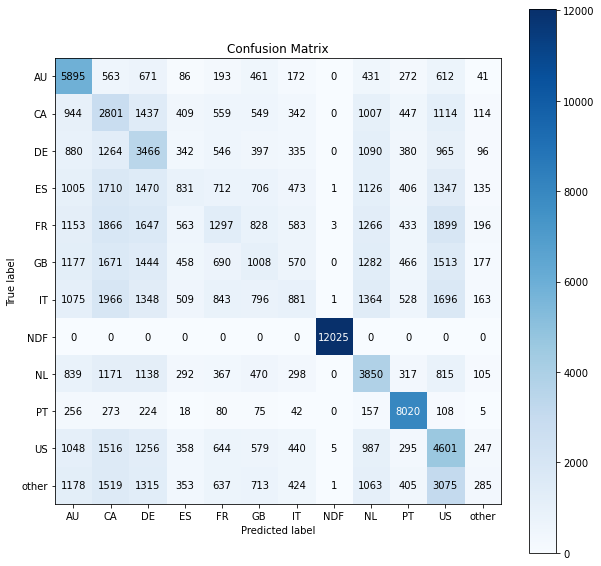

In [59]:
#Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

#Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize= False, figsize=(10,10))

#Balanced Accuracy
balanced_accuracy = m.balanced_accuracy_score(y_test_nn, yhat_nn )
print('Balanced Accuracy: {}'.format(balanced_accuracy))

#Kappa Metrics
kappa_score = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_score))

#Objetivo é aumentar o Balanced Accuracy para uns 85% (Acuracia para apresentar ao time de negocio
#Kappa Score uns 75% (Nivel de concordancia entre as classes).

#print(m.classification_report(y_val_nn, yhat_nn))

## Calculando a quantidade de auto vetores para o PCA

In [ ]:
k = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)

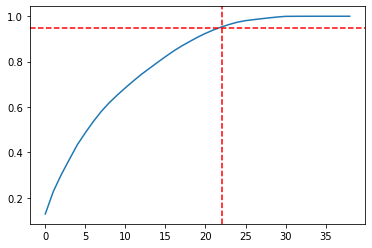

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(22, color='red', linestyle='--')
plt.axhline(0.95, color='red', linestyle='--')


## Cross Validation

In [8]:
#Split Training and validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [11]:
num_folds = 5

balanced_acc_list = []
kappa_acc_list = []
i = 1 

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

# PCA
#Standardization (Centraliza e rescalar)
ss = pp.StandardScaler()
x_train_scaler = ss.fit_transform(x_train)
x_val_scaler = ss.transform(x_val)

#Define the number of eigenvectors (autovetor) + eigenvalues (Autovalores)
pca = d.PCA().fit(x_train_scaler)
k = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)

#Change data to new space
pca = d.PCA(k).fit(x_train_scaler)

x_train = pca.transform(x_train_scaler)
x_val = pca.transform(x_val_scaler)

In [12]:
for train_ix, val_ix in kfold.split(x_train, y_train):
    print('Fold Number: {}/{}'.format(i, num_folds))
#
#    ##get fold
    x_train_folds = x_train[train_ix]
    y_train_folds = y_train.iloc[train_ix]
#
    x_val_fold = x_train[val_ix]
    y_val_folds = y_train.iloc[val_ix]
#
    
    #Target Hot-encoding
    ohe = pp.OneHotEncoder()
#
    y_train_folds_nn = ohe.fit_transform( y_train_folds.values.reshape( -1, 1)).toarray() #Precisamos transformar nosso y_train neste formato, pois rede neural so aceita dessa forma.
#
#
    ## MLP: Neural Network
    ## Model definition
    model = Sequential()
#
    model.add(Dense(128, input_dim = x_train.shape[1], activation='relu'))
    model.add(Dense(12, activation='softmax'))
#
    ## model compile
    #opt = SGD( lr= 0.01, momentum= 0.8)
#
    model.compile( loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
#
    
    model.fit(x_train_folds, y_train_folds_nn, epochs=100, verbose=0)
#
    ##Prediction
    pred_nn = model.predict(x_val_fold)
#
    ##Invert prediction
    yhat_nn = ohe.inverse_transform(pred_nn)
#
    ##Prediction prepare
    y_val_nn = y_val_folds.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]
#
    ##Metrics
    
    #Balanced Accuracy
    balanced_acc_nn = m.balanced_accuracy_score(y_val_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)

    ##Kappa Metric

    kappa_acc_nn = m.cohen_kappa_score(y_val_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
#
    
    i += 1

Fold Number: 1/5


2022-12-27 11:44:51.583059: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-12-27 11:44:51.583090: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: wellington-IPMH510G
2022-12-27 11:44:51.583095: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: wellington-IPMH510G
2022-12-27 11:44:51.583209: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-12-27 11:44:51.583225: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.85.2
2022-12-27 11:44:51.583229: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.85.2
2022-12-27 11:44:51.584168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in p

5673/5673 [==============================] - 2s 401us/step
Fold Number: 2/5
5673/5673 [==============================] - 2s 419us/step
Fold Number: 3/5
5673/5673 [==============================] - 2s 413us/step
Fold Number: 4/5
5673/5673 [==============================] - 2s 408us/step
Fold Number: 5/5
5673/5673 [==============================] - 2s 411us/step


In [13]:
print('Avg Balanced Accuracy: {} +/- {}'.format(np.round( np.mean(balanced_acc_list), 2), np.round(np.std(balanced_acc_list),4)))

print('Avg Kappa Accuracy: {} +/- {}'.format(np.round( np.mean(kappa_acc_list),4), np.round( np.std(kappa_acc_list),4)))

Avg Balanced Accuracy: 0.36 +/- 0.0044
Avg Kappa Accuracy: 0.2983 +/- 0.0043
